## Comment Analyzer
This is a file that works through some strategies for analyzing student comments written by teachers. I am using my own comments from that last 3 years as a initial data. 

I tried a some topic modeling as well as sentiment analysis. I used the sentiment scores to find comments where anomalous in some way. 

In [1]:
import spacy 
import numpy as np
import pandas as pd

In [3]:
nlp = spacy.load('en_core_web_sm')

In [13]:
df = pd.read_csv('Comments_2019_v2.txt', sep="\n")
df.columns= ["Comment"]

Teacher comments are typically written in a document where paragraphs separate students. 

This structures that form of comment document into a DataFrame and tokenizes the comment.

In [5]:
def name_extract(df): 
    names = []
    for i in df.index:
        doc_iter = nlp(df["Comment"][i])
        sents = [sent for sent in doc_iter.sents]
        if len(sents) == 1: 
            names.append(sents[0])
            df.drop(i, axis=0, inplace=True)
    return names

In [14]:
students = name_extract(df)

In [15]:
df["student names"] = students

In [16]:
# structure the comments by first name, last name, and comment
df['last name'] = df['student names'].apply(lambda x: x[1])
df['first name'] = df['student names'].apply(lambda x: x[0])
df.drop('student names', axis = 1, inplace=True)

## Topic modeling

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=.94, min_df=2, stop_words='english')

In [50]:
dtm = tfidf.fit_transform(df['Comment'])

In [51]:
from sklearn.decomposition import NMF
nmf_model = NMF(random_state=101, n_components=4)

In [52]:
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=4, random_state=101, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [53]:
for index,topic in enumerate(nmf_model.components_):
   print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
   print([tfidf.get_feature_names()[i] for i in topic.argsort()[-20:]])
   print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['feel', 'test', 'quarter', 'year', 'extra', 'review', 'scores', 'unfamiliar', 'situations', 'apply', 'quiz', 'knowledge', 'questions', 'solid', 'new', 'excellent', 'material', 'work', 'started', 'great']


THE TOP 20 WORDS FOR TOPIC #1
['build', 'necessary', 'confused', 'feeling', 'use', 'postulates', 'overwhelmed', 'significantly', 'skills', 'proofs', 'proof', 'theorems', 'year', 'test', 'geometry', 'assessment', 'expect', 'time', 'chapter', 'writing']


THE TOP 20 WORDS FOR TOPIC #2
['lines', 'mind', 'draw', 'proof', 'visualize', 'spatial', 'congruent', 'diagram', 'manipulate', 'head', 'higher', 'separating', 'development', 'diagrams', 'long', 'paying', 'orientation', 'understand', 'skills', 'shapes']


THE TOP 20 WORDS FOR TOPIC #3
['school', 'socializing', 'struggled', 'job', 'difficulty', 'year', 'left', 'time', 'solving', 'good', 'improve', 'spring', 'topics', 'challenging', 'material', 'problems', 'work', 'second', 'exam', 'semester']




There are topics here that can be separated though I do not have enough well varied data to create more clear topics

## Sentiment Analysis

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [17]:
df['scores'] = df['Comment'].apply(lambda comment: sid.polarity_scores(comment)) # assign sentiment scores

df['negative'] = df['scores'].apply(lambda score_dict: score_dict['neg'])
df['positive'] = df['scores'].apply(lambda score_dict: score_dict['pos'])
df['neutral'] = df['scores'].apply(lambda score_dict: score_dict['neu'])
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])

df.drop(['scores', 'first name', 'last name'], axis=1, inplace=True)

In [18]:
df.head()

,Comment,negative,positive,neutral,compound
1,With consistently solid scores thus far in the...,0.042,0.247,0.712,0.9852
3,"Vasudha, excellent job thus far this year. You...",0.024,0.216,0.760,0.9766
5,"Geometry has been tough this year, Gia but I a...",0.056,0.223,0.721,0.9904
7,"Solid start to the second semester, JJ you see...",0.047,0.226,0.727,0.9743
9,"Great work this semester, Sean you seem to be ...",0.078,0.256,0.666,0.9841


In [19]:
desc_df = df.describe()
desc_df

,negative,positive,neutral,compound
count,200.000000,200.000000,200.000000,200.000000
mean,0.044035,0.186180,0.769850,0.934564
std,0.028776,0.047939,0.051209,0.111539
min,0.000000,0.071000,0.581000,-0.165500
25%,0.020000,0.151000,0.733000,0.934650
50%,0.042000,0.182000,0.770000,0.967500
75%,0.060000,0.220250,0.807000,0.980225
max,0.117000,0.359000,0.884000,0.995400


In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'neutral distribution')

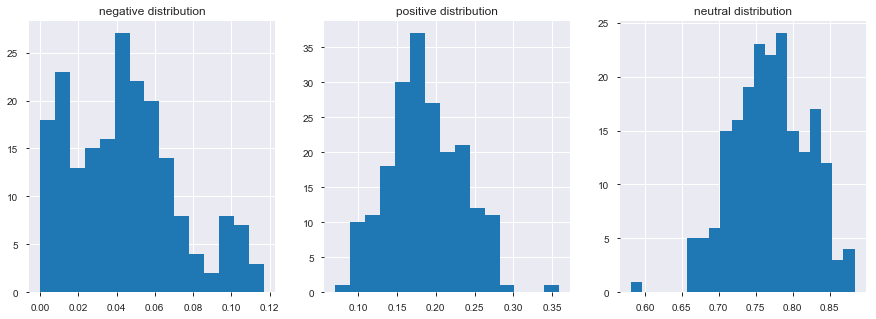

In [60]:
fig = plt.figure(figsize=(15,5)) # Let's look at score distribution. 
ax = fig.add_subplot(131)
ax = df.negative.hist(bins=15)
ax.set_title('negative distribution')
ax1 = fig.add_subplot(132)
ax1 = df.positive.hist(bins=15)
ax1.set_title('positive distribution')
ax2 = fig.add_subplot(133)
ax2 = df['neutral'].hist(bins=20)
ax2.set_title('neutral distribution')


# Let's look at how this sentiment scores play out in terms of comments

First, let's look at the highest negative and positive scores to see they match up to what we know about the students.

Strugglers should have a very high negative score and below average positive scores.

Should be a pretty direct comment if they need help in a specific topic area.

In [26]:
one_std_top_quarter_neg = desc_df['negative'][6]+ desc_df['negative'][2]
one_std_top_quarter_pos = desc_df['positive'][6]+ desc_df['positive'][2]
mean_positive = desc_df['positive'][1]
df[(df['negative'] >= one_std_top_quarter_neg) & (df['positive']<= mean_positive)]

,Comment,negative,positive,neutral,compound
25,Great job taking on some very challenging subj...,0.102,0.143,0.755,0.9005
67,"Academically, you have started the second seme...",0.099,0.140,0.761,0.6597
81,Trigonometry has been very challenging for you...,0.116,0.185,0.700,0.9446
141,With consistently solid scores thus far in the...,0.096,0.153,0.751,0.7600
151,"After a very challenging start to the year, Co...",0.097,0.130,0.773,0.7735
187,"Phineas, you had a great start to year scoring...",0.117,0.157,0.727,0.7688
191,"Self-advocacy, maximizing time in class, and c...",0.109,0.168,0.723,0.8793
257,"After a tough start to the second semester, I ...",0.089,0.168,0.743,0.9549
299,With a dogged work ethic and meticulous attent...,0.102,0.165,0.734,0.7430
303,"This semester has been a challenge for you, Au...",0.105,0.152,0.743,0.8272


These student above have largely struggled in math. A few exceptions stand out though.

In [23]:
highest_positive = desc_df['positive'][7]-1.5*(desc_df['positive'][2])
df[df['positive'] >= highest_positive]

,Comment,negative,positive,neutral,compound
27,"Great second semester, Grant your work is cons...",0.06,0.359,0.581,0.9807
389,With consistently excellent test and quiz scor...,0.00,0.299,0.701,0.9929


The students within 1.5 standard deviations from the maximum positive score seem to make sense. 

In [24]:
highest_positive_2std = desc_df['positive'][7]-2*(desc_df['positive'][2])
df[df['positive'] >= highest_positive_2std]

,Comment,negative,positive,neutral,compound
27,"Great second semester, Grant your work is cons...",0.060,0.359,0.581,0.9807
77,"Excellent second semester thus far, Harry your...",0.018,0.274,0.708,0.9845
121,"Great start to the year, Talia you really seem...",0.013,0.277,0.710,0.9887
159,"Great job thus far, Grant you have deep unders...",0.049,0.268,0.684,0.9698
195,With consistently excellent test and quiz scor...,0.000,0.268,0.732,0.9914
199,With consistently excellent test and quiz scor...,0.013,0.282,0.706,0.9934
281,I know the spring exam did not go the way you ...,0.000,0.267,0.733,0.9954
353,"Keeping in the family tradition, Antonie you h...",0.020,0.266,0.714,0.9814
361,With consistently excellent test and quiz scor...,0.000,0.269,0.731,0.9906
371,With consistently excellent test and quiz scor...,0.000,0.279,0.721,0.9923


If I open up to two standard deviations from the maximum postive score, a few more potential spurious results show up. So does a very familiar comment type. 

In [27]:
#one standard deviation from the 75% mark in negative comment and greater than the 75% in positive
top_quarter_pos = desc_df['positive'][6] 
top_quarter_neg = desc_df['negative'][6]
df[(df['negative'] >= top_quarter_neg) & (df['positive']>= one_std_top_quarter_pos)]

,Comment,negative,positive,neutral,compound
27,"Great second semester, Grant your work is cons...",0.06,0.359,0.581,0.9807


For students with very high negative score and high positive scores there doesn't seem to be a reason from there actual performance to merit such a negative score. These comments have very similar comment types so there must be something about the comment type that makes VADER think the sentiment is highly negative.

In [28]:
bottom_quarter_pos = desc_df['positive'][4]
bottom_quarter_neg = desc_df['negative'][4] 
df[(df['negative'] <= bottom_quarter_neg) & (df['positive'] <= bottom_quarter_pos)]

,Comment,negative,positive,neutral,compound
57,"Luiza, you continue to produce excellent, thor...",0.014,0.128,0.858,0.9022
107,"Solid start to the year, Brady your participat...",0.017,0.102,0.881,0.9078
125,"Solid start to the year, Luiza you seem to und...",0.020,0.151,0.829,0.9336
145,Consistency is the name of game in honors geom...,0.020,0.141,0.839,0.9126
251,Consistent daily preparation will be essentia...,0.013,0.116,0.871,0.9766
313,"Solid start to the year, Sophie your participa...",0.014,0.149,0.836,0.9690
333,"Solid start to the year, Max you seem to under...",0.012,0.148,0.840,0.9488
357,"Solid start to the year, Tess you seem to unde...",0.015,0.148,0.837,0.9675
373,"Self-advocacy, maximizing time in class, and c...",0.013,0.112,0.875,0.9520
385,"Great start to the year, Jonathan you seem to ...",0.014,0.138,0.848,0.9565


The students above have bottom quarter negative scores and bottom quarter of positive scores. Mamy of these students are solid performers so it could that not enough good things are being said about them. It is also possible the comment analyzer isn't picking up on the correct words. One thing that could be helpful is relating the indicator grade range to sentiment to check for high performing students with low sentiment scores. 

The comment type could also be an issue. Might just be a really bland comment type. 


Let's look at the highest neutral comments next

In [29]:
df[df['neutral'] >= desc_df['neutral'][6]+desc_df['neutral'][2]]

,Comment,negative,positive,neutral,compound
107,"Solid start to the year, Brady your participat...",0.017,0.102,0.881,0.9078
251,Consistent daily preparation will be essentia...,0.013,0.116,0.871,0.9766
301,Consistent daily preparation will be essentia...,0.042,0.099,0.860,0.7748
359,We changed the course curriculum this year for...,0.045,0.071,0.884,0.6391
373,"Self-advocacy, maximizing time in class, and c...",0.013,0.112,0.875,0.9520


Blah Blah Blah - these are probably the most boring or unhelpful comments written. Low positive and negative scores with very high neutral scores. Notice the start of many of these. 